In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import ndimage
from keras.datasets import mnist
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
def pool_forward(x,mode="max"):
    #m*n_c*w*h
    x_patches = x.reshape(x.shape[0],x.shape[1]//2, 2,x.shape[2]//2, 2,x.shape[3])
    if mode=="max":
        out = x_patches.max(axis=2).max(axis=3)
        mask  =np.isclose(x,np.repeat(np.repeat(out,2,axis=1),2,axis=2)).astype(int)
    elif mode=="average": 
        out =  x_patches.mean(axis=3).mean(axis=4)
        mask = np.ones_like(x)*0.25
    return out,mask

In [3]:
def pool_backward(dx, mask):
    return mask*(np.repeat(np.repeat(dx,2,axis=1),2,axis=2))

In [4]:
def relu(x, deriv=False):
    if deriv:
        return (x>0)
    return np.multiply(x, x>0)

In [5]:
def conv_forward(x,w,b,padding="same"):
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    n = (x.shape[1]-w.shape[0]+2*pad) +1 #ouput width/height
    y = np.zeros((x.shape[0],n,n,w.shape[3]))
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    w = np.flip(w,0)
    w = np.flip(w,1)
    
    f = w.shape[0]
        
    for i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                y[i,:,:,k]= y[i,:,:,k]+ ndimage.convolve(x_padded[i,:,:,d],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
                #ndimage.convolve starts convolution from centre of kernel and zero pads but we don't want this
                #since we want to manually decide if we want to pad or not
    y = y + b
    return y

In [6]:
def fc_forward(x,w,b):
    return relu(w.dot(x)+b)


In [7]:
def fc_backward(dA,a,x,w,b):
    m = dA.shape[1]
    dZ = dA*relu(a,deriv=True)
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [8]:
def softmax_forward(x,w,b):
    z = w.dot(x)+b
    z -= np.mean(z,axis=0,keepdims=True)
    a = np.exp(z) 
    a = a/np.sum(a,axis=0,keepdims=True)
    return a+1e-8

In [9]:
def softmax_backward(y_hat, y, w, b, x):
    m = y.shape[1]
    dZ = y_hat - y
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [10]:
def conv_backward(dZ,x,w,padding="same"):
    m = x.shape[0]
    db = (1/m)*np.sum(dZ, axis=(0,1,2), keepdims=True)
    
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #this will allow us to broadcast operation
    x_padded_bcast = np.expand_dims(x_padded, axis=-1)
    dZ_bcast = np.expand_dims(dZ, axis=-2)
    
    dW = np.zeros_like(w)
    f=w.shape[0]
    w_x = x_padded.shape[1]
    for i in range(f):
        for j in range(f):
            dW[i,j,:,:] = (1/m)*np.sum(dZ_bcast*x_padded_bcast[:,i:w_x-(f-1 -i),j:w_x-(f-1 -j),:,:],axis=(0,1,2))  
    
    dx = np.ones_like(x_padded)*0.0
    Z_pad = f-1
    dZ_padded = np.pad(dZ,((0,0),(Z_pad,Z_pad),(Z_pad,Z_pad),(0,0)),'constant', constant_values = 0)  
    for i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                dx[i,:,:,d]+=ndimage.convolve(dZ_padded[i,:,:,k],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
    dx = dx[:,pad:dx.shape[1]-pad,pad:dx.shape[2]-pad,:]
    return dx,dW,db

Next to define the model:


In [11]:
def init_conv_parameters(f, n_c, k):
    
    return 0.025*np.random.normal(size=(f,f,n_c,k)), 0.015+np.random.rand(1,1,1,k)
                                                                      
def init_fc_parameters(n_x,n_y):
    return 0.001*np.random.normal(size=(n_y,n_x)),0.015+np.random.rand(n_y,1)

In [12]:
def initialise_parameters():    
    parameters={}
    parameters["W_conv1"], parameters["b_conv1"] = init_conv_parameters(5, 1, 16)
    parameters["W_conv2"], parameters["b_conv2"] = init_conv_parameters(5, 16, 16)

    parameters["W_conv3"], parameters["b_conv3"] = init_conv_parameters(3, 16, 32)
    parameters["W_conv4"], parameters["b_conv4"] = init_conv_parameters(3, 32,64)

    parameters["W_fc1"],parameters["b_fc1"] = init_fc_parameters(3136,1024)
    parameters["W_softmax"],parameters["b_softmax"] = init_fc_parameters(1024,10)

    return parameters


In [13]:
def forward_prop(X,parameters):
    
    cache={}
    
    cache["z_conv1"] = conv_forward(X,parameters["W_conv1"], parameters["b_conv1"])
    cache["a_conv1"] = relu(cache["z_conv1"])

    cache["z_conv2"] = conv_forward(cache["a_conv1"],parameters["W_conv2"], parameters["b_conv2"])
    cache["a_conv2"] = relu(cache["z_conv2"])

    cache["z_pool1"], cache["mask_pool1"] = pool_forward(cache["a_conv2"])
    
 

    cache["z_conv3"] = conv_forward(cache["z_pool1"],parameters["W_conv3"], parameters["b_conv3"])
    cache["a_conv3"] = relu(cache["z_conv3"])
    
 

    cache["z_conv4"] = conv_forward(cache["a_conv3"],parameters["W_conv4"], parameters["b_conv4"] )
    cache["a_conv4"] = relu(cache["z_conv4"])
    
 
    cache["z_pool2"], cache["mask_pool2"] = pool_forward(cache["a_conv4"])


    cache["a_flatten"] = np.reshape(cache["z_pool2"], (cache["z_pool2"].shape[0],-1)).T

 
    cache["a_fc1"] = fc_forward( cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    
    return softmax_forward(cache["a_fc1"],parameters["W_softmax"],parameters["b_softmax"]),cache

In [14]:
def backprop(X,Y,Y_pred,parameters,cache,lambd):
    grads = {}
    
    dA, grads["dW_softmax"],grads["db_softmax"] =softmax_backward(Y_pred, Y, parameters["W_softmax"],parameters["b_softmax"],cache["a_fc1"])

    dA, grads["dW_fc1"],grads["db_fc1"] = fc_backward(dA,cache["a_fc1"],cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    dA = np.reshape(dA.T,cache["z_pool2"].shape)
    grads["dz_pool2"] = dA
    dA = pool_backward(dA, cache["mask_pool2"])
    
    dA = dA*relu(cache["z_conv4"],deriv=True)
    grads["da_conv4"] = dA
    dA, grads["dW_conv4"],grads["db_conv4"] = conv_backward(dA,cache["a_conv3"],parameters["W_conv4"])
    
    dA = dA*relu(cache["z_conv3"],deriv=True)
    grads["da_conv3"] = dA
    dA, grads["dW_conv3"],grads["db_conv3"] = conv_backward(dA,cache["z_pool1"],parameters["W_conv3"])
    
    grads["dz_pool1"] = dA
    dA = pool_backward(dA, cache["mask_pool1"])

    
    dA = dA*relu(cache["z_conv2"],deriv=True)
    grads["da_conv2"] = dA
    dA, grads["dW_conv2"],grads["db_conv2"] = conv_backward(dA,cache["a_conv1"],parameters["W_conv2"])
    
    
    dA = dA*relu(cache["z_conv1"],deriv=True)
    grads["da_conv1"] = dA
    grads["dx"], grads["dW_conv1"],grads["db_conv1"] = conv_backward(dA,X,parameters["W_conv1"])
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]= grads[key]+ (lambd/X.shape[0])*parameters[key[1:]] 
    return grads        

In [15]:
def loss_function(y_pred,y,parameters,lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost

In [16]:
def accuracy(y_pred,y):
    preds = np.argmax(y_pred,axis=0)
    truth = np.argmax(y,axis=0)
    return np.mean(np.equal(preds,truth).astype(int))

In [17]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 10
    num_sample = 5
    flag = True
    print("Checking gradients...")
    for param in reversed(list(parameters.keys())):
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold or num_grad==0:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
            print("Relative error: " + str(rel_error))
            flag = False
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out

In [18]:
def visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred):
    fig2, ax = plt.subplots(3,8)
    ax[0,0].imshow(X_train_minibatch[0,:,:,0], cmap="gray")
    ax[0,1].imshow(cache["a_conv1"][0,:,:,0],cmap="gray") 
    ax[0,2].imshow(cache["a_conv2"][0,:,:,0],cmap="gray") 
    ax[0,3].imshow(cache["z_pool1"][0,:,:,0],cmap="gray") 
    ax[0,4].imshow(cache["a_conv3"][0,:,:,0],cmap="gray") 
    ax[0,5].imshow(cache["a_conv4"][0,:,:,0],cmap="gray") 
    ax[0,6].imshow(cache["z_pool2"][0,:,:,0],cmap="gray") 
    ax[0,7].bar(np.arange(10),y_pred[:,0])
    ax[0,7].set_ylim([0,1])


    ax[1,0].imshow(minibatch_grads["dx"][0,:,:,0],cmap="gray") 
    ax[1,1].imshow(minibatch_grads["da_conv1"][0,:,:,0],cmap="gray")
    ax[1,2].imshow(minibatch_grads["da_conv2"][0,:,:,0],cmap="gray") 
    ax[1,3].imshow(minibatch_grads["dz_pool1"][0,:,:,0],cmap="gray") 
    ax[1,4].imshow(minibatch_grads["da_conv3"][0,:,:,0],cmap="gray") 
    ax[1,5].imshow(minibatch_grads["da_conv4"][0,:,:,0],cmap="gray") 
    ax[1,6].imshow(minibatch_grads["dz_pool2"][0,:,:,0],cmap="gray") 
    ax[1,7].bar(np.arange(10),(y_pred-Y_train_minibatch)[:,0])
    ax[1,7].set_ylim([-1,1])


    ax[2,0].imshow(parameters["W_conv1"][:,:,0,0], cmap="gray")
    ax[2,1].imshow(parameters["W_conv2"][:,:,0,0],cmap="gray") 
    ax[2,2].imshow(parameters["W_conv3"][:,:,0,0],cmap="gray") 
    ax[2,3].imshow(parameters["W_conv4"][:,:,0,0],cmap="gray") 
    ax[2,4].imshow(minibatch_grads["dW_conv1"][:,:,0,0],cmap="gray") 
    ax[2,5].imshow(minibatch_grads["dW_conv2"][:,:,1,1],cmap="gray") 
    ax[2,6].imshow(minibatch_grads["dW_conv3"][:,:,2,2],cmap="gray") 
    ax[2,7].imshow(minibatch_grads["dW_conv4"][:,:,3,3],cmap="gray") 
    fig2.canvas.draw()
   #check activations aren't blowing up or dead relu neurons
    for key in cache.keys():
        if "a_" in key:
            print(key + ": " + str(np.max(cache[key])))
            if np.max(cache[key])==0:
                print("DEAD RELU")
                backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)


In [19]:
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate,parameters = initialise_parameters() ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    momentum = {}
    beta = 0.9
    for param in parameters:
        momentum[param] = np.zeros_like(parameters[param]) 

    
    for epoch in tqdm_notebook(range (num_epochs), total=num_epochs,desc="Number of Epochs"):
        print("Training the model, epoch: " + str(epoch+1))
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(0,X_train.shape[0]//batch_size), total =X_train.shape[0]//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, cache = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, cache,lambd)
            
            #visualise the activations and gradients
            if (i%5==0):
                visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred)
         
            #update the parameters using gradient descent
            for param in parameters.keys():
                momentum[param] = beta *  momentum[param] + minibatch_grads["d"+param]
                parameters[param] = parameters[param] - learning_rate* momentum[param]
            
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            print("Training set error: "+ str(minibatch_cost))

            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%10 == 0):
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

In [20]:
def process_input(X,Y):
    X = np.reshape(X,(X.shape[0], 28,28,1))
    X= X/255 #normalise input features 
    Y = np.eye(10)[Y.reshape(-1)].T
    
    idx = np.random.permutation(np.arange(X.shape[0]))
    
    X = X[idx]
    Y = Y[:,idx]
    return X,Y

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process_input(x_train, y_train)
x_test , y_test = process_input(x_test , y_test)

<IPython.core.display.Javascript object>


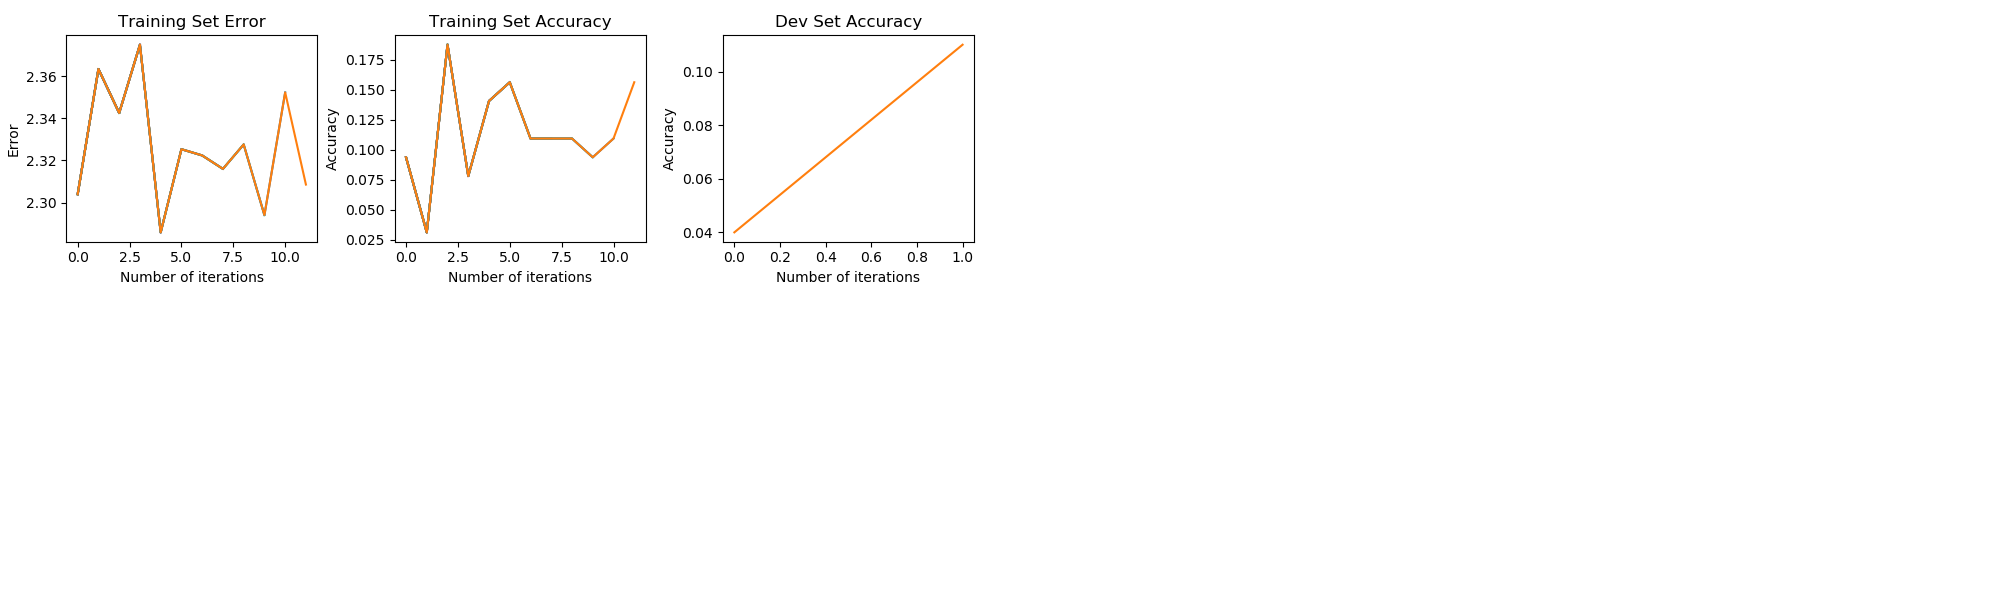

Training the model, epoch: 1


<IPython.core.display.Javascript object>


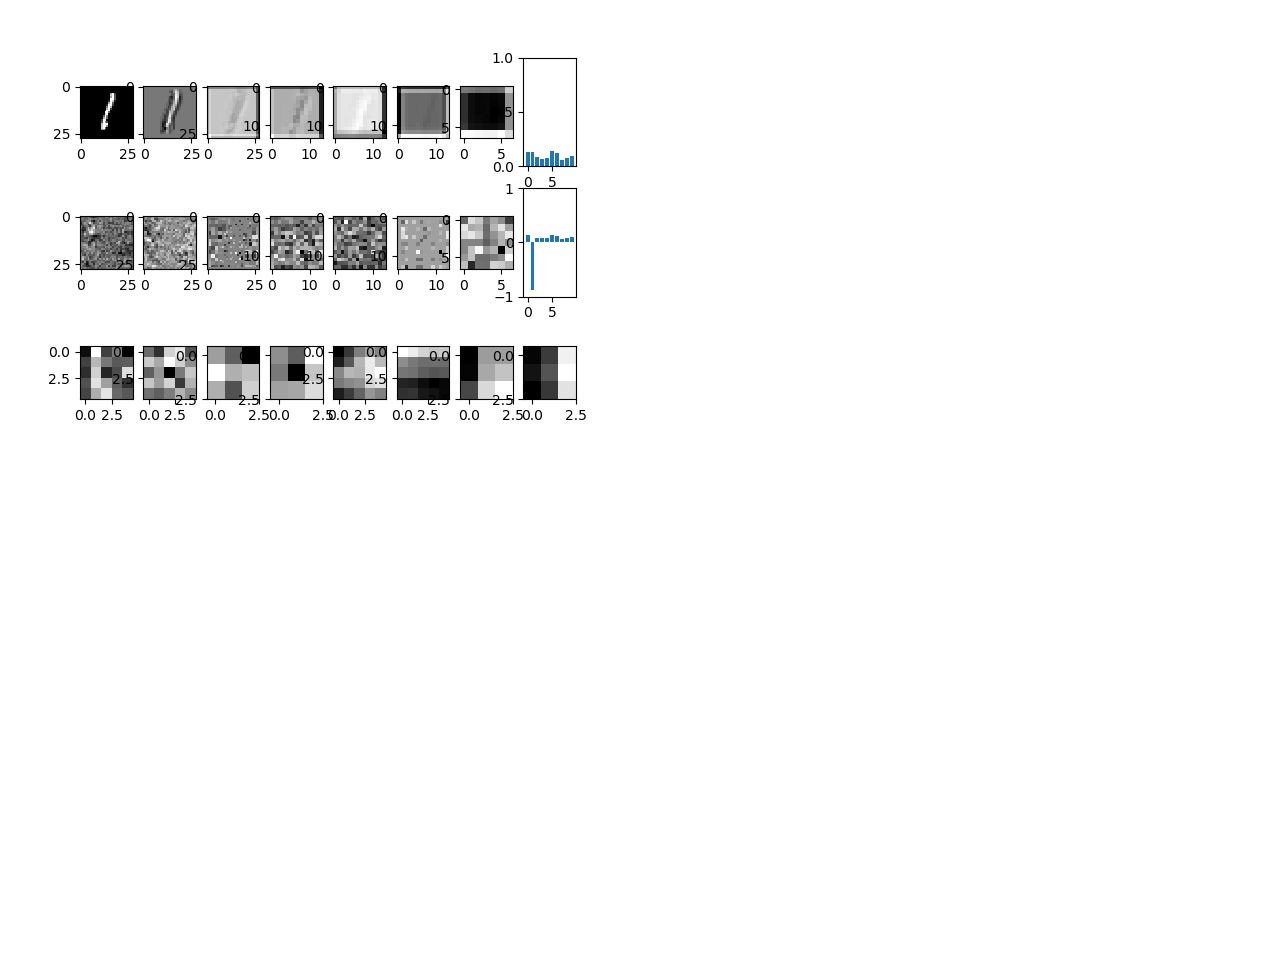

a_conv1: 1.1669310239951851
a_conv2: 1.3563574437092791
a_conv3: 1.4323519000018865
a_conv4: 1.2517427210425223
a_flatten: 1.2517427210425223
a_fc1: 1.054540457329856
Training set error: 2.3039854309443033
Training set accuracy: 0.09375
Accuracy on dev set: 0.04
Training set error: 2.363378305267167
Training set error: 2.3425237079441246
Training set error: 2.374914795253778
Training set error: 2.285880141595683


<IPython.core.display.Javascript object>


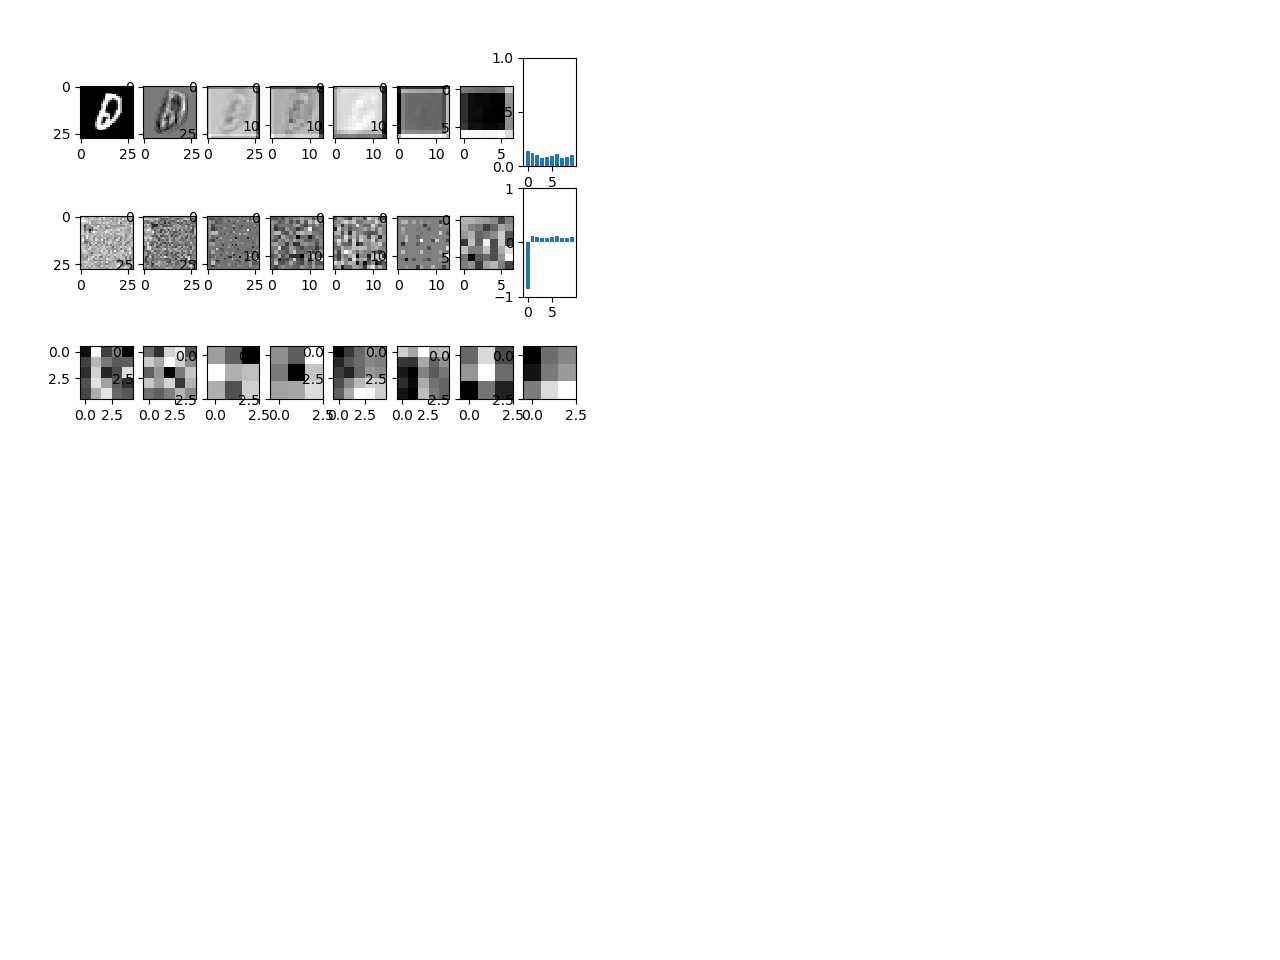

a_conv1: 1.1735882695560609
a_conv2: 1.3573045414107567
a_conv3: 1.4332571555832265
a_conv4: 1.2543129942942444
a_flatten: 1.2543129942942444
a_fc1: 1.0535121563073648
Training set error: 2.325330859585619
Training set error: 2.3223670541699417
Training set error: 2.3159903622772022
Training set error: 2.3275850540070175
Training set error: 2.29404438432394


<IPython.core.display.Javascript object>


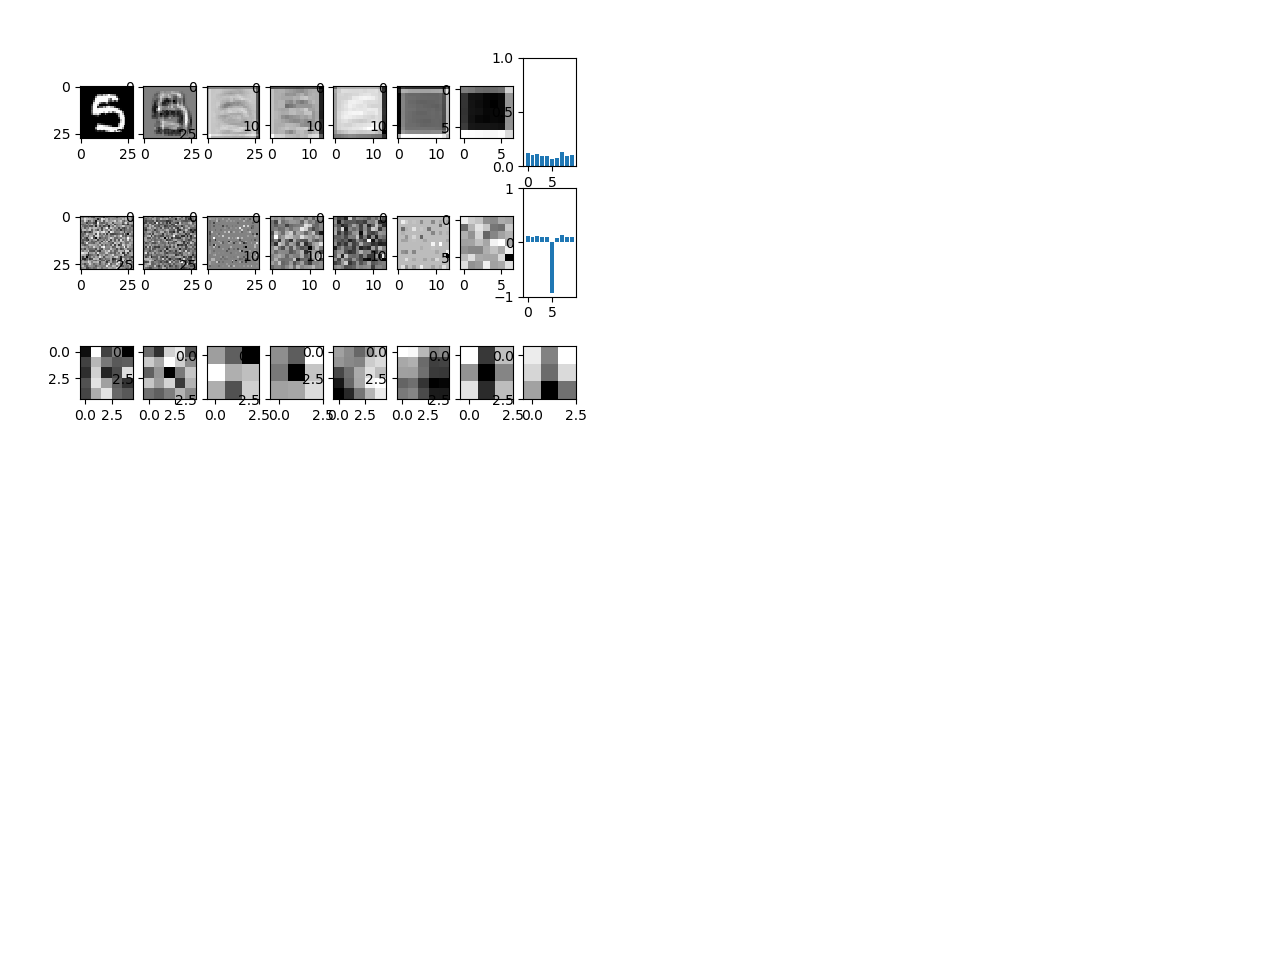

a_conv1: 1.1667681948204751
a_conv2: 1.3550037573370053
a_conv3: 1.4333332947138973
a_conv4: 1.2533301756358162
a_flatten: 1.2533301756358162
a_fc1: 1.0529210125494797
Training set error: 2.3522826080048294
Training set accuracy: 0.109375
Accuracy on dev set: 0.11
Training set error: 2.308551117487564


In [ ]:
parameters =train_model(x_train,y_train,x_test[:100],y_test[:,:100],
                        num_epochs=50,batch_size=64,lambd=0,learning_rate=1e-3)

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])